In [18]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import sys

In [23]:
DEBUG_MODE = True

SyntaxError: 'return' outside function (3961300748.py, line 5)

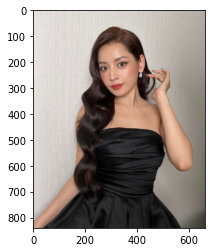

In [8]:
BLOCK_SIZE = 8 # blocksize 
img1 = cv2.imread("image01.png")
h, w = np.array(img1.shape[:2])//B * B
img1= img1[:h, :w]

#Convert BGR to RGB
img2=np.zeros(img1.shape,np.uint8)
img2[:,:,0]=img1[:,:,2]
img2[:,:,1]=img1[:,:,1]
img2[:,:,2]=img1[:,:,0]

if DEBUG_MODE:
    plt.imshow(img2)

In [9]:
QY=np.array([[16,11,10,16,24,40,51,61],
                         [12,12,14,19,26,48,60,55],
                         [14,13,16,24,40,57,69,56],
                         [14,17,22,29,51,87,80,62],
                         [18,22,37,56,68,109,103,77],
                         [24,35,55,64,81,104,113,92],
                         [49,64,78,87,103,121,120,101],
                         [72,92,95,98,112,100,103,99]])

QC=np.array([[17,18,24,47,99,99,99,99],
                         [18,21,26,66,99,99,99,99],
                         [24,26,56,99,99,99,99,99],
                         [47,66,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99]])

In [10]:
Y_d =cv2.cvtColor(img1, cv2.COLOR_BGR2YCrCb)

In [11]:
SSV=2
SSH=2
crf=cv2.boxFilter(Y_d[:,:,1],ddepth=-1,ksize=(2,2))
cbf=cv2.boxFilter(Y_d[:,:,2],ddepth=-1,ksize=(2,2))
crsub=crf[::SSV,::SSH]
cbsub=cbf[::SSV,::SSH]
imSub=[Y_d[:,:,0], crsub, cbsub]

In [14]:
QUANLITY_FACTOR = 19.0 
if QUANLITY_FACTOR < 50 and QUANLITY_FACTOR > 1:
        scale = np.floor(5000/QUANLITY_FACTOR)
elif QUANLITY_FACTOR < 100:
        scale = 200-2*QUANLITY_FACTOR
else:
        print("Quality Factor must be in the range [1..99]")
scale = scale / 100.0
Q=[QY*scale,QC*scale,QC*scale]

In [15]:
scol=  BLOCK_SIZE
srow = BLOCK_SIZE

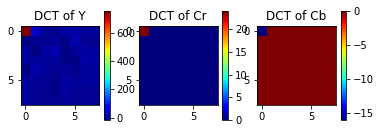

In [17]:
TransAll=[]
TransAllQuant=[]
ch=['Y','Cr','Cb']
plt.figure()
for idx,channel in enumerate(imSub):
        plt.subplot(1,3,idx+1)
        channelrows=channel.shape[0]
        channelcols=channel.shape[1]
        Trans = np.zeros((channelrows,channelcols), np.float32)
        TransQuant = np.zeros((channelrows,channelcols), np.float32)
        blocksV=channelrows // B
        blocksH=channelcols // B
        vis0 = np.zeros((channelrows,channelcols), np.float32)
        vis0[:channelrows, :channelcols] = channel
        vis0=vis0-128 # convert 0-255 to -127 to 127
        for row in range(blocksV):
                for col in range(blocksH):
                        currentblock = cv2.dct(vis0[row*B:(row+1)*B,col*B:(col+1)*B])
                        Trans[row*B:(row+1)*B,col*B:(col+1)*B] = currentblock
                        TransQuant[row*B:(row+1)*B,col*B:(col+1)*B] = np.round(currentblock/Q[idx])
        TransAll.append(Trans)
        TransAllQuant.append(TransQuant)
        if idx==0:
                selectedTrans=Trans[srow*B:(srow+1)*B,scol*B:(scol+1)*B]
        else:
                sr=int(np.floor(srow/SSV))
                sc=int(np.floor(scol/SSV))
                selectedTrans=Trans[sr*B:(sr+1)*B,sc*B:(sc+1)*B]
        if DEBUG_MODE:
            plt.imshow(selectedTrans,cmap=cm.jet,interpolation='nearest')
            plt.colorbar(shrink=0.5)
            plt.title('DCT of '+ch[idx])

In [9]:
DecAll=np.zeros((h,w,3), np.uint8)
for idx,channel in enumerate(TransAllQuant):
        channelrows=channel.shape[0]
        channelcols=channel.shape[1]
        blocksV=channelrows//B
        blocksH=channelcols//B
        back0 = np.zeros((channelrows,channelcols), np.uint8)
        for row in range(blocksV):
                for col in range(blocksH):
                        dequantblock=channel[row*B:(row+1)*B,col*B:(col+1)*B]*Q[idx]
                        currentblock = np.round(cv2.idct(dequantblock))+128
                        currentblock[currentblock>255]=255
                        currentblock[currentblock<0]=0
                        back0[row*B:(row+1)*B,col*B:(col+1)*B]=currentblock
        back1=cv2.resize(back0,(w,h))
        DecAll[:,:,idx]=np.round(back1)

In [10]:
type(img1.shape)

tuple

Sum of squared error:  10587.245297998908


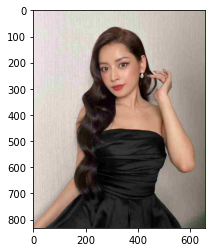

In [11]:
reImg=cv2.cvtColor(DecAll, cv2.COLOR_YCrCb2RGB)
# reImg = np.reshape(reImg, (reImg.shape[1], reImg.shape[0], reImg.shape[2]))
# cv2.imwrite('BackTransformedQuant.jpg', reImg)
plt.figure()
img3=np.zeros(img1.shape,np.uint8)
img3[:,:,0]=reImg[:,:,2]
img3[:,:,1]=reImg[:,:,1]
img3[:,:,2]=reImg[:,:,0]

SSE=np.sqrt(np.sum((img2-img3)**2))
print("Sum of squared error: ",SSE)
# normalization shape

img3 = img3[:-8,:-8,:]
plt.imshow(img3[:,:,::-1])
cv2.imwrite('BackTransformedQuant.jpg', img3)

plt.show()

In [12]:
w

664

In [13]:
a = [1, 2, 3, 4, 5, 6,7, 8, 9]
print(a[:-1])

[1, 2, 3, 4, 5, 6, 7, 8]
